In [1]:
import sys
import os
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_nlp_pkg')
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_model_explain_pkg')
import nlpbasic.textClean as textClean
import nlpbasic.docVectors as DocVector
import nlpbasic.dataExploration as DataExploration
import nlpbasic.lda as lda
import nlpbasic.tfidf as tfidf

import model_explain.plot as meplot
import model_explain.shap as meshap

import data_visualization.distribution_plot as dbplot

from numpy import array,asarray,zeros
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import re
import pycountry
import seaborn as sns
import plotly.express as px

import matplotlib
import matplotlib.dates as mdates
root_path = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\NLP_data'

In [2]:
def de_emojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')
def tweet_proc(df, text_col='text'):
    df['orig_text'] = df[text_col]
    # Remove twitter handles
    df[text_col] = df[text_col].apply(lambda x:re.sub('@[^\s]+','',x))
    # Remove URLs
    df[text_col] = df[text_col].apply(lambda x:re.sub(r"http\S+", "", x))
    # Remove emojis
    df[text_col] = df[text_col].apply(de_emojify)
    # Remove hashtags
    df[text_col] = df[text_col].apply(lambda x:re.sub(r'\B#\S+','',x))
    return df[df[text_col]!='']
def get_clean_country(text):
    for country in pycountry.countries:
        if country.name in text:
            return country.name
def get_vacc_brand(sentence):
    vax_dict = {
    'covaxin':'covaxin', 
    'sinopharm':'sinopharm', 
    'sinovac':'sinovac', 
    'moderna':'moderna', 
    'pfizer':'pfizer', 
    'biontech':'pfizer', 
    'oxford':'astrazeneca', 
    'astrazeneca':'astrazeneca', 
    'sputnik':'sputnik'
    }
    for o in list(vax_dict.keys()):
        if sentence.lower().__contains__(o):
            return vax_dict.get(o)
    else:
        return 'Others'


In [3]:
raw_data = pd.read_csv(os.path.join(root_path, "covidvacc_tweet_sentiment_emo.csv"))
data = raw_data[raw_data.text.isnull()==False]
# data = data[['user_name','date','user_location','user_description','user_created','user_followers','user_friends','user_favourites','user_verified','text','hashtags','source','orig_text','emotion','sentiment']]
data = data.drop_duplicates()
data = tweet_proc(data,'text')
data['country'] = data.user_location.apply(lambda x: get_clean_country(str(x)))
data['date']=pd.to_datetime(data['date'], errors='coerce').dt.date
data['vacc_brand'] = data.text.apply(lambda x: get_vacc_brand(x))


In [4]:
data.head(3)

,Unnamed: 0,Unnamed: 0.1,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,...,hashtags,source,retweets,favorites,is_retweet,orig_text,emotion,sentiment,country,vacc_brand
0,0,0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,...,['PfizerBioNTech'],Twitter for Android,0,0.0,False,Same folks said daikon paste could treat a cyt...,worry,negative,None,Others
1,1,1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,...,NaN,Twitter Web App,1,1.0,False,While the world has been on the wrong side of ...,worry,positive,None,Others
2,2,2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0.0,False,Russian vaccine is created to last 2-4 y...,neutral,neutral,None,Others


In [5]:
len(data)

88977

In [85]:
len(raw_data)

88977

## Analyze Sentiment over Time for different country

In [9]:
sentiment_overtime = data.groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()
fig = px.line(sentiment_overtime, x='date', y='tweets', color='sentiment', category_orders={'sentiment': ['neutral', 'negative', 'positive']},
             title='Timeline showing sentiment of tweets about COVID-19 vaccines')
fig.show()

In [15]:
emo_overtime = data[~data.emotion.isin(['neutral','worry'])].groupby(['date', 'emotion']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()
fig = px.line(emo_overtime, x='date', y='tweets', color='emotion', category_orders={'emotion': ['anger', 'boredom', 'enthusiasm', 'fun', 'happiness', 'hate', 'love', 'neutral', 'relief', 'sadness', 'surprise', 'worry']},
             title='Timeline showing emotion of tweets about COVID-19 vaccines')
fig.show()

In [30]:
country_overtime = data[~data.country.isin(['India'])].groupby(['date', 'country']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()
fig = px.line(country_overtime, x='date', y='tweets', color='country',
             title='Timeline showing country of tweets about COVID-19 vaccines')
fig.show()

In [75]:
india_overtime = data[data.country.isin(['India'])].groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()
fig = px.line(india_overtime, x='date', y='tweets', color='sentiment',
             title='Timeline showing emotion of tweets in India about COVID-19 vaccines')
fig.show()

In [76]:
canada_overtime = data[data.country.isin(['Canada'])].groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()
fig = px.line(canada_overtime, x='date', y='tweets', color='sentiment',
             title='Timeline showing emotion of tweets in Canada about COVID-19 vaccines')
fig.show()

In [78]:
canada_overtime = data[(data.country.isin(['Canada']))&(data.sentiment == 'negative')].groupby(['date', 'emotion']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()
fig = px.line(canada_overtime, x='date', y='tweets', color='emotion',
             title='Timeline showing emotion of tweets in Canada about COVID-19 vaccines')
fig.show()

In [37]:
china_overtime = data[data.country.isin(['China'])].groupby(['date', 'emotion']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()
fig = px.line(china_overtime, x='date', y='tweets', color='emotion', category_orders={'emotion': ['anger', 'boredom', 'enthusiasm', 'fun', 'happiness', 'hate', 'love', 'neutral', 'relief', 'sadness', 'surprise', 'worry']},
             title='Timeline showing emotion of tweets in China about COVID-19 vaccines')
fig.show()

## Sentiment analysis for different vacc

In [88]:
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik']

# Note: a lot of the tweets seem to contain hashtags for multiple vaccines even though they are specifically referring to one vaccine - not very helpful!
def filtered_vacc(df, vax):
    df = df.dropna()
    df_filt = pd.DataFrame()
    for o in vax:
        df_filt = df_filt.append(df[df['orig_text'].str.lower().str.contains(o)])
    other_vax = list(set(all_vax)-set(vax))
    for o in other_vax:
        df_filt = df_filt[~df_filt['orig_text'].str.lower().str.contains(o)]
    print('vaccine ', vax, len(df_filt))
    return df_filt

covaxin = filtered_vacc(raw_data, ['covaxin'])
sinopharm = filtered_vacc(raw_data, ['sinopharm'])
sinovac = filtered_vacc(raw_data, ['sinovac'])
moderna = filtered_vacc(raw_data, ['moderna'])
pfizer = filtered_vacc(raw_data, ['pfizer','biontech'])
oxford = filtered_vacc(raw_data, ['oxford','astrazeneca'])
sputnik = filtered_vacc(raw_data, ['sputnik'])

vaccine  ['covaxin'] 767
vaccine  ['sinopharm'] 157
vaccine  ['sinovac'] 155
vaccine  ['moderna'] 863
vaccine  ['pfizer', 'biontech'] 641
vaccine  ['oxford', 'astrazeneca'] 392
vaccine  ['sputnik'] 906


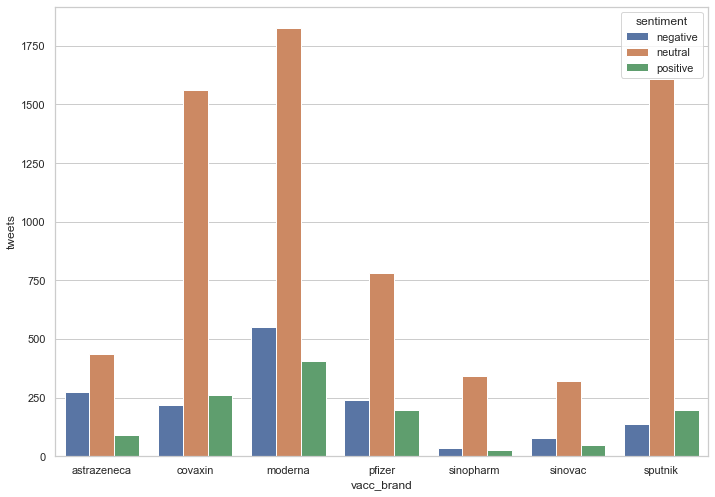

In [6]:
data_overtime = data.groupby(['vacc_brand', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="vacc_brand", y="tweets", hue="sentiment", data=data_overtime[data_overtime.vacc_brand!='Others'])

## Side Effect

In [171]:
def find_side_effect(df):
    df = df.dropna()
    df_filt = pd.DataFrame()
    effect = ['side','effect','side effect','fever','headache']
    for o in effect:
        df_filt = df_filt.append(df[df['orig_text'].str.lower().str.contains('side effect')])
    print('vaccine ', len(df_filt))
    return df_filt

side_effect = find_side_effect(data).reset_index(drop=True)
side_effect = side_effect[side_effect.sentiment=='negative']
side_effect['explore_text'] = textClean.pipeline(side_effect['text'].to_list(), multi_gram = [1], lower_case=True, 
                                                 deacc=False, encoding='utf8', errors='strict', stem_lemma = 'lemma', 
                                                 tag_drop = [], nltk_stop=True, 
                                                 stop_word_list=['effect','vaccine','side','covid'], 
                                                 check_numbers=False, word_length=2, remove_consecutives=True)

vaccine  1055


In [172]:
print(DataExploration.get_topn_freq_bow(list(side_effect['explore_text']), topn = 30))

[('effect', 270), ('first', 60), ('get', 60), ('arm', 55), ('shot', 55), ('feel', 50), ('day', 35), ('sore', 30), ('hour', 25), ('dose', 25), ('far', 25), ('second', 25), ('jab', 25), ('amp', 25), ('serious', 25), ('may', 20), ('vaccinate', 20), ('today', 20), ('mild', 20), ('like', 20), ('less', 15), ('bit', 15), ('headache', 15), ('th', 15), ('sleep', 15), ('take', 15), ('pain', 15), ('experienced', 15), ('great', 15), ('week', 15)]


In [173]:
print(tfidf.get_top_n_tfidf_bow(list(side_effect['explore_text']), top_n_tokens = 30))

['say', 'amp', 'far', 'complete', 'although', 'experience', 'morning', 'yesterday', 'sore', 'rare', 'serious', 'stop', 'countr', 'still', 'upper', 'already', 'great', 'thats', 'nearly', 'sledgehammer', 'moment', 'st', 'available', 'monitor', 'particularly', 'patient', 'hav', 'cause', 'bad', 'well']


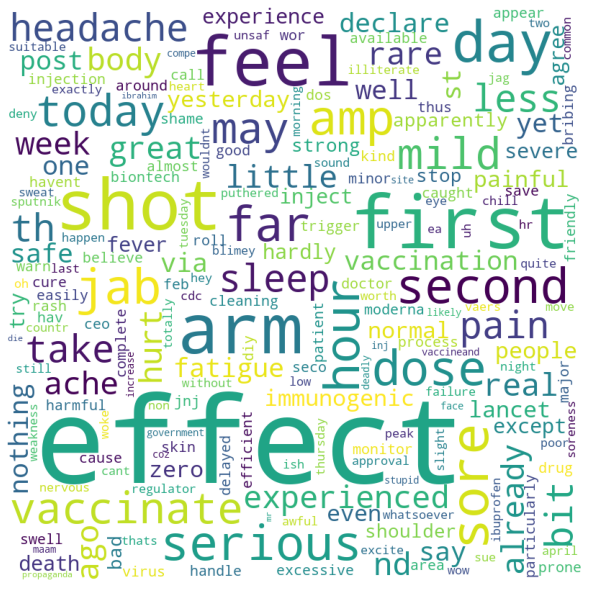

In [174]:
DataExploration.generate_word_cloud(list(side_effect['explore_text']))

In [162]:
no_topics = 10
lda_allbow, bow_corpus, dictionary = lda.fit_lda(list(side_effect['explore_text']), num_topics = 10)
lda.lda_topics(lda_allbow)

,Topics,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10
0,1,ache,arm,feel,body,far,shot,second,fever,today,like
1,2,shot,make,dose,well,feel,first,rare,public,get,next
2,3,read,vaccine,know,expert,need,precaution,kid,click,get,possible
3,4,first,feel,mild,amp,zero,normal,safe,report,arm,update
4,5,amp,first,today,safe,get,serious,immunogenic,nd,lancet,ago
5,6,get,dose,first,vaccinate,far,shot,today,experience,st,day
6,7,vaccine,common,shot,vaccination,first,india,second,yesterday,feel,jab
7,8,shot,day,get,arm,pain,first,sleep,sore,people,update
8,9,moderna,report,study,via,hour,jab,take,first,new,pfizer
9,10,get,say,do,one,receive,far,jab,st,also,second


In [150]:
side_effect.emotion.value_counts()

worry        408
neutral      201
happiness     18
love           3
sadness        3
Name: emotion, dtype: int64

In [175]:
def plot_count(feature, title, df, size=1, ordered=True):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    if ordered:
        g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set3')
    else:
        g = sns.countplot(df[feature], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()

In [186]:
fig = px.histogram(data, x="country")
fig.show()

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


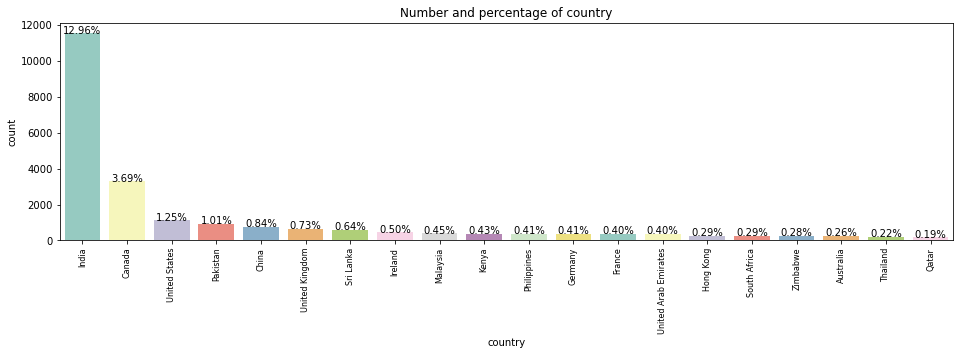

In [4]:
dbplot.plot_count_dist("country", "country", data, 4, True)

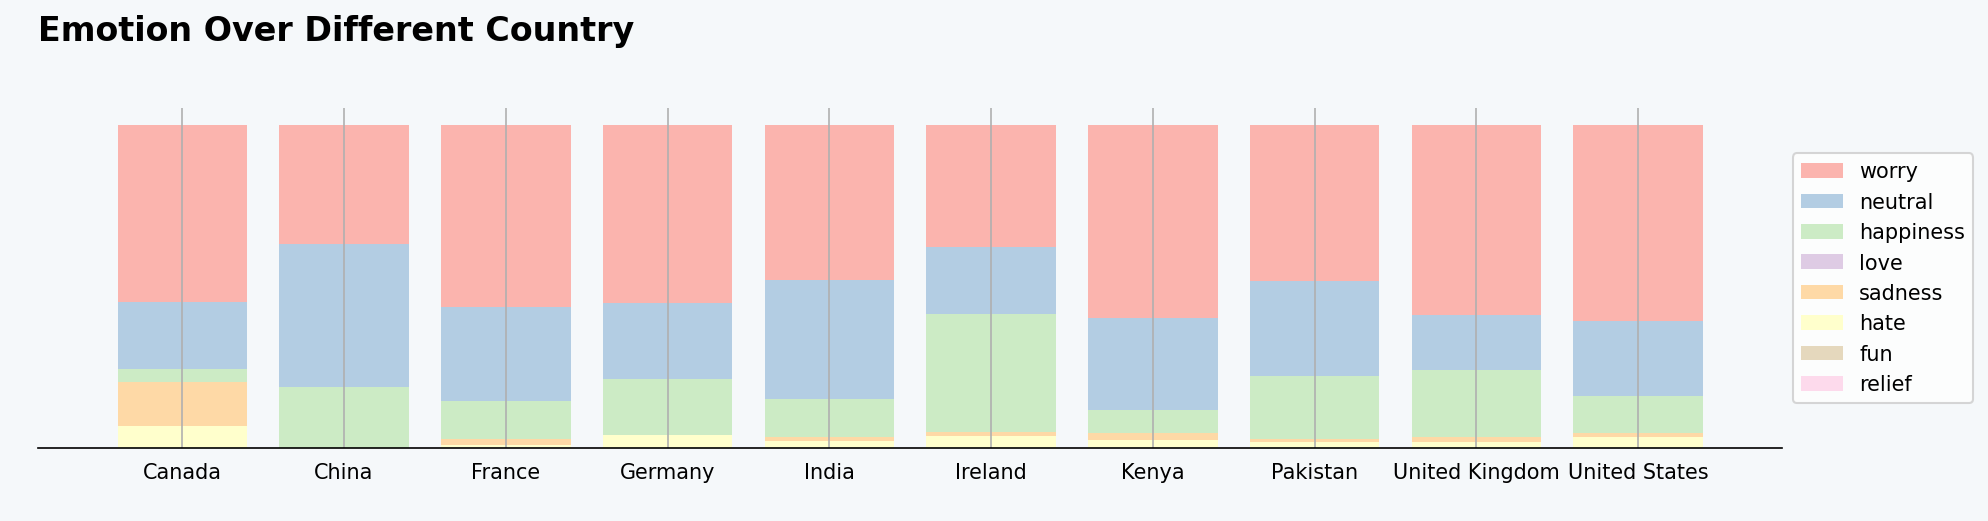

In [5]:
dbplot.generate_bar_proportion(data[data.sentiment!='neutral'], 'emotion', 'country', color = 0, order = True, topn = 10)

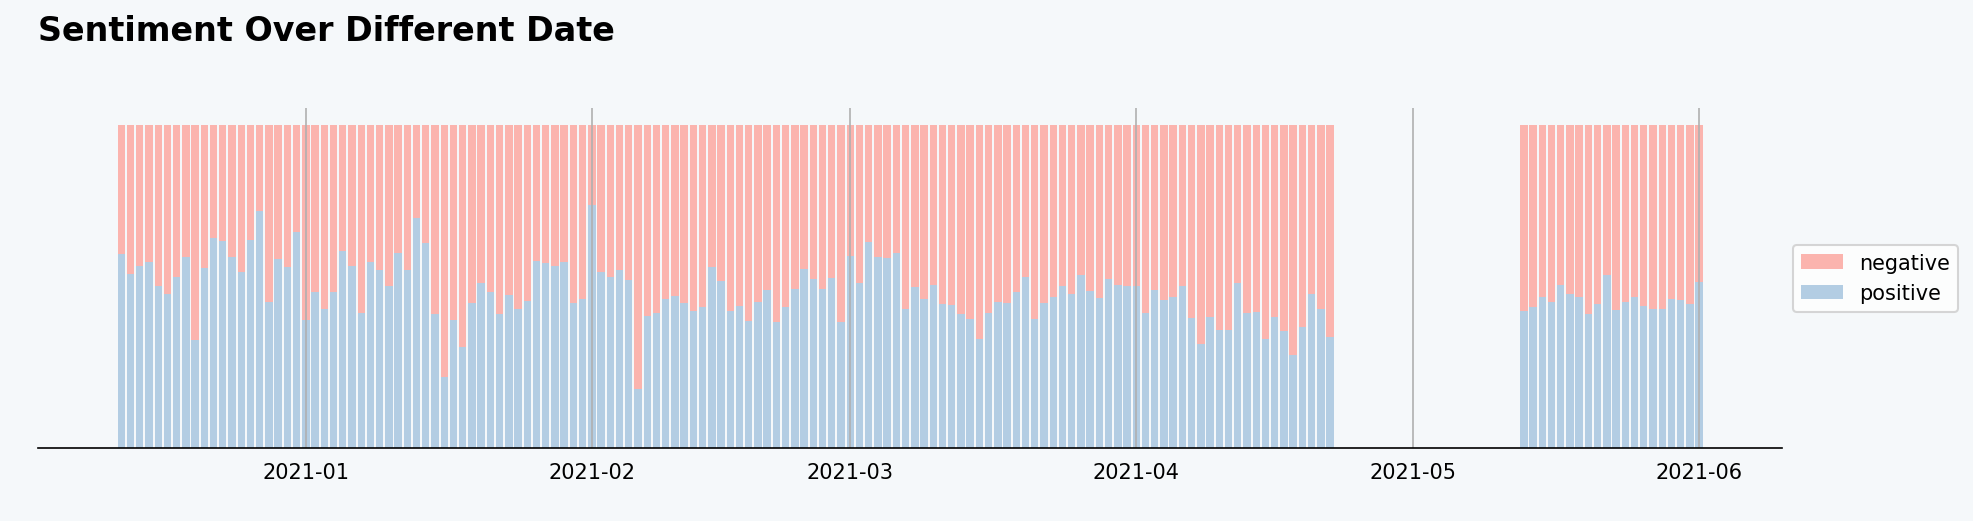

In [6]:
dbplot.generate_bar_proportion(data[data.sentiment!='neutral'], 'sentiment', 'date', color = 0, order = False, topn = 10)

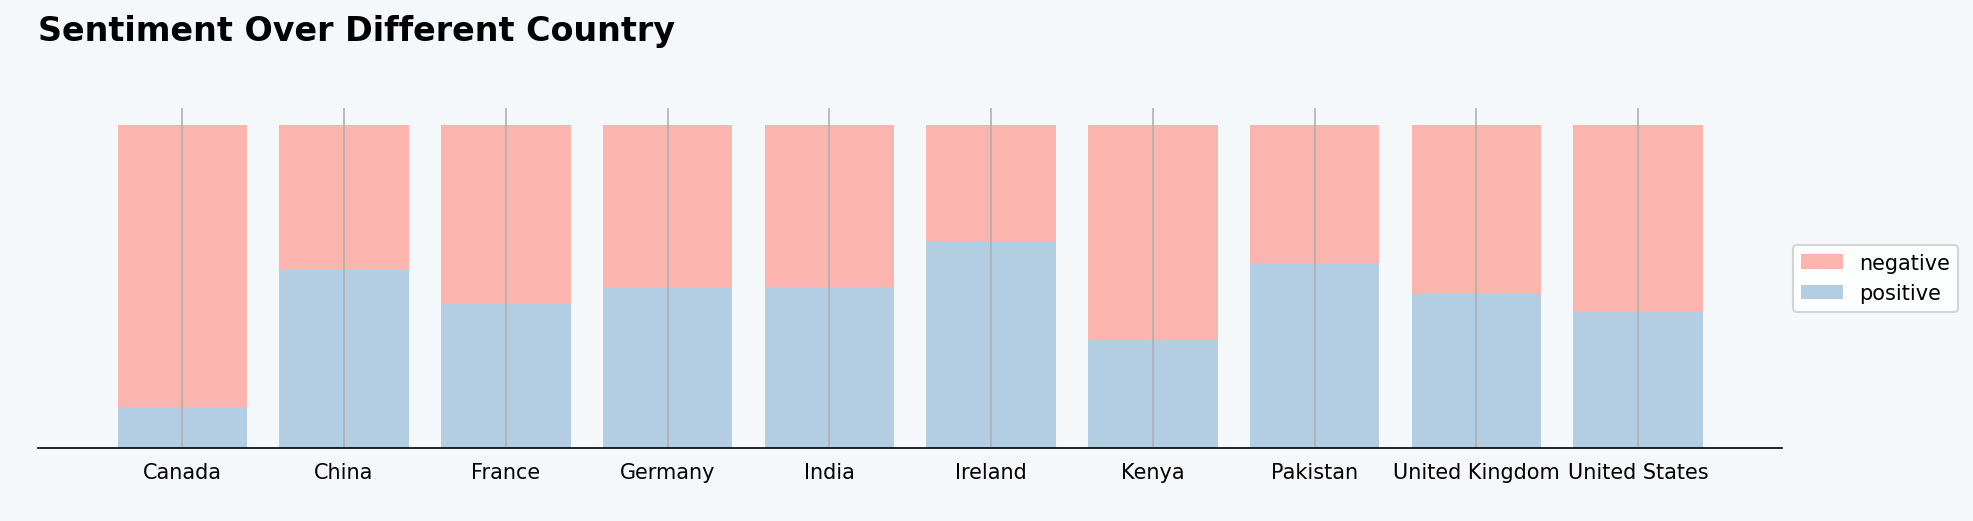

In [7]:
dbplot.generate_bar_proportion(data[data.sentiment!='neutral'], 'sentiment', 'country', color = 0, order = True, topn = 10)